# Projeto Final Algoritmos Genéticos: Otimização de vidros a prova de bala

#### Trio: csv_Computeiros_sinápticos_virtuais 

#### Integrantes: Diogo Pereira de Lima Carvalho, José David Sales e Mayllon Emmanoel Pequeno

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glasspy.predict import GlassNet
from glasspy.data import SciGlass
from functools import partial
import seaborn as sns
 
from funcoes import cria_populacao_compostos as cria_populacao
from funcoes import funcao_objetivo_pop as funcao_objetivo_pop
from funcoes import selecao_torneio_min as funcao_selecao
from funcoes import cruzamento_ponto_simples_e_duplo as funcao_cruzamento
from funcoes import mutacao_sucessiva as funcao_mutacao_1
from funcoes import mutacao_simples as funcao_mutacao_2
from funcoes import mutacao_troca as funcao_mutacao_3
from funcoes import preco_composicao

<p style="text-align: justify"><h5> O objetivo do notebook abaixo é a implementação de um algoritmo genético que busque a melhor composição para vidros à prova de bala considerando apenas compostos óxidos. O algoritmo conta com a criação de uma população, seleção de indivíduos, cruzamento, mutação e atualização no hall da fama. As constantes utilizadas no decorrer do algoritmo são declaradas abaixo </h5></p>

In [ ]:
df_compounds_and_prices = pd.read_csv('../analise_exploratoria/Prices.csv',sep=',')

COMPOUNDS = list(df_compounds_and_prices['Oxide Coumpounds'])
PRECOS = list(df_compounds_and_prices['Price per gram(dolar/gram)'])
NUM_COMPOUNDS = len(COMPOUNDS)
VALOR_MAX_COMPOUNDS = 20

TAMANHO_POPULACAO = 1000
NUM_GERACOES = 2
CHANCE_DE_CRUZAMENTO = 0.5
CHANCE_DE_MUTACAO = 0.05
CHANCE_DE_MUTACAO_POR_GENE = 0.25
TAMANHO_TORNEIO = 3

<p style="text-align: justify"><h5>Uma instância do GlassNet é criada, esse modelo é o que posteriormente utilizaremos para fazer a predição das propriedades do material vítreo com base nos compostos informados. Também é criada uma função objetivo parcial já contendo os parâmetros necessários para a resolução de um problema específico do código atual</h5></p>

In [ ]:
#source = SciGlass()
MODEL = GlassNet()

funcao_objetivo = partial(funcao_objetivo_pop, lista_de_compostos=COMPOUNDS, lista_de_precos=PRECOS, modelo=MODEL)

<p style="text-align: justify"><h5> A evolução do algoritmo genético é descrita abaixo. Nela, uma população é criada com os parâmetros dos compostos dados, nessa população, indivíduos são aleatoriamente selecionados com base em seu “fitness”, a função de cruzamento duplo é chamada e mistura o material genético entre pares dos indivíduos selecionados. Após, isso, três funções de mutações são aplicadas, sendo elas: simples, sucessiva e de troca. A etapa de mutação é de extrema importância, pois, permite a incorporação de informação nova no sistema. Após isso o hall da fama é atualizado com o indivíduo de menor valor de “fitness”</h5></p>

A função objetivo computa um score baseado na equação abaixo:

$$
Score = \frac{\sqrt{(\frac{ModuloYoung}{ModuloYoung_{MAX}} - 1)^2 + (\frac{Microdureza}{Microdureza_{MAX}} - 1)^2 + (\frac{Preco}{Preco_{MIN}} - 1)^2}}{\sqrt[3]{NumeroCompostosNaoUtilizados + 1}}
$$

In [ ]:
populacao = cria_populacao(TAMANHO_POPULACAO, NUM_COMPOUNDS, VALOR_MAX_COMPOUNDS)

hall_da_fama = []

geracoes =[]
melhores_das_geracoes = []
melhores_hardness = []
melhores_modulos_young = []
melhores_precos = []
composicoes_melhores = []
numeros_de_compostos_usados = []

for n in range(NUM_GERACOES):
    print(f'Geração {n}', end='\r') 
    
    # Seleção
    fitness = funcao_objetivo(populacao)        
    selecionados = funcao_selecao(populacao, fitness, TAMANHO_TORNEIO)
    
    # Cruzamento
    proxima_geracao = []
    for pai, mae in zip(selecionados[::2], selecionados[1::2]):
        individuo1, individuo2 = funcao_cruzamento(pai, mae, CHANCE_DE_CRUZAMENTO)
        proxima_geracao.append(individuo1)
        proxima_geracao.append(individuo2)
    
    # Mutação
    funcao_mutacao_1(proxima_geracao, CHANCE_DE_MUTACAO, CHANCE_DE_MUTACAO_POR_GENE, VALOR_MAX_COMPOUNDS)
    funcao_mutacao_2(proxima_geracao, CHANCE_DE_MUTACAO, VALOR_MAX_COMPOUNDS)
    funcao_mutacao_3(proxima_geracao, CHANCE_DE_MUTACAO)
        
    # Atualização do hall da fama
    fitness = funcao_objetivo(proxima_geracao)
        
    menor_fitness = min(fitness)
    indice = fitness.index(menor_fitness)
    hall_da_fama.append(proxima_geracao[indice])    
        
    melhor_individuo_geracao = hall_da_fama[n]
    dict_composition = dict(zip(COMPOUNDS, melhor_individuo_geracao))
    predicao = MODEL.predict(dict_composition)
    preco_melhor_local = preco_composicao(melhor_individuo_geracao, PRECOS)

        
    dicionario_composicao_limpa = {chave: valor for chave, valor in dict_composition.items() if valor != 0}
    numero_de_compostsos = len(list(dicionario_composicao_limpa.keys()))
        
    melhores_das_geracoes.append(menor_fitness)
    melhores_hardness.append(predicao['Microhardness'].iloc[0])
    melhores_modulos_young.append(predicao['YoungModulus'].iloc[0])
    melhores_precos.append(preco_melhor_local)
    composicoes_melhores.append(dicionario_composicao_limpa)
    numeros_de_compostos_usados.append(numero_de_compostsos)
    geracoes.append(n+1)
    
    # Encerramento
    populacao = proxima_geracao
    
    
    evolucao = pd.DataFrame()
    evolucao['Gerações'] = geracoes
    evolucao['Score'] = melhores_das_geracoes
    evolucao['Microhardness'] = melhores_hardness
    evolucao['Módulo de Young'] = melhores_modulos_young
    evolucao['Preços'] = melhores_precos
    evolucao['Número de compostos usados']=numeros_de_compostos_usados
    evolucao['Composição'] = composicoes_melhores
    evolucao.to_excel('Melhores de cada geração.xlsx')
        
fitness = funcao_objetivo(hall_da_fama)
menor_fitness = min(fitness)
indice = fitness.index(menor_fitness)
melhor_individuo_observado = hall_da_fama[indice]
melhor_individuo_observado

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0]

<p style="text-align: justify"><h5>Abaixo podemos verificar a quantidade de compostos utilizados na composição do melhor indivíduo observado. Objetivamos também minimizar a quantidade de compostos usados</h5></p>

In [ ]:
compostos_usados = len(list(dict_composition.values())) - (list(dict_composition.values())).count(0)

print(f"{compostos_usados}/{len(COMPOUNDS)} compostos utilizados")

3/126 compostos utilizados


In [ ]:
preco = preco_composicao(melhor_individuo_observado, PRECOS)

print(f"Preço: {preco}")
print(f"Módulo de Young: {float(predicao['YoungModulus'].iloc[0])}")
print(f"Microdureza: {float(predicao['Microhardness'].iloc[0])}")

Preço: 0.3003529411764706
Módulo de Young: 113.79553978015426
Microdureza: 8.867958309753316


<p style="text-align: justify"><h5>Abaixo, relacionamos os genes do melhor indivíduo observado com a ordem de composição informada, utilizando também o modelo preditivo para obter as propriedades do material vítreo com base na composição do melhor indivíduo.</h5></p>

In [ ]:
dict_composition = dict(zip(COMPOUNDS, melhor_individuo_observado))
dict_composition_no_zeros = {chave: valor for chave, valor in dict_composition.items() if valor != 0}

print(f'Valores arbitrários de cada composto: {dict_composition_no_zeros}')

Valores arbitrários de cada composto: {'Li2CO3': 6, 'Ca(NO3)2': 6, 'AlPO4': 5}


In [ ]:
candidato_relacao_por_grama = np.array(melhor_individuo_observado)/sum(melhor_individuo_observado) if sum(melhor_individuo_observado) != 0 else 0

dict_candidato_relacao_por_grama = {chave: round(valor, 3) for chave, valor in dict(zip(COMPOUNDS, candidato_relacao_por_grama)).items() if valor != 0}
display(dict_candidato_relacao_por_grama)

lista_compostos_utilizados = list(dict_candidato_relacao_por_grama.keys())

print(f'Valores de cada composto em porcentagem de grama: {dict_candidato_relacao_por_grama}')

{'Li2CO3': 0.353, 'Ca(NO3)2': 0.353, 'AlPO4': 0.294}

Valores de cada composto em porcentagem de grama: {'Li2CO3': 0.353, 'Ca(NO3)2': 0.353, 'AlPO4': 0.294}


In [ ]:
dict_precos_utilizados = {chave: valor for chave, valor in dict(zip(COMPOUNDS, PRECOS)).items() if chave in lista_compostos_utilizados}
print(f'Preços por grama dos compostos utilizados: {dict_precos_utilizados}')

Preços por grama dos compostos utilizados: {'Li2CO3': 0.249, 'Ca(NO3)2': 0.292, 'AlPO4': 0.372}


In [ ]:
df_compounds_and_prices['Price per gram(dolar/gram)'].describe()

count    126.000000
mean      19.570842
std       65.880195
min        0.022800
25%        0.502725
50%        2.820000
75%       10.550000
max      593.000000
Name: Price per gram(dolar/gram), dtype: float64

Text(0, 0.5, 'Melhor Score')

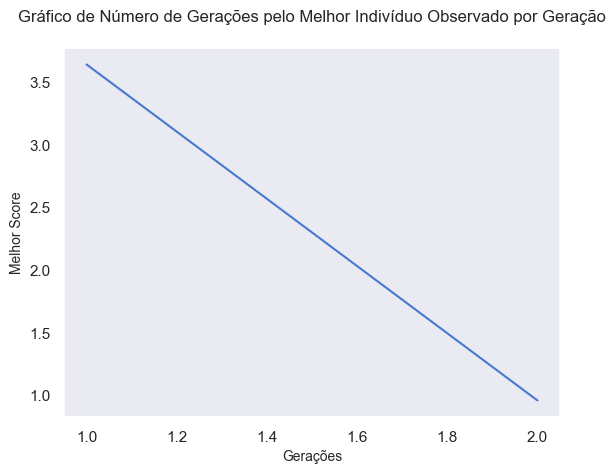

In [ ]:
sns.set(style='dark', palette='muted')
plt.plot(geracoes,melhores_das_geracoes)
plt.title('Gráfico de Número de Gerações pelo Melhor Indivíduo Observado por Geração\n', fontsize=12)
plt.xlabel('Gerações', fontsize=10)
plt.ylabel('Melhor Score', fontsize=10)